In [1]:
%load_ext autoreload
%autoreload 2
from IPython.core.display import display, HTML
display(HTML("<style>.container { width:100% !important; }</style>"))


import os 
os.chdir("..")

In [3]:
from numerics.integration.steps import *
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm
from numerics.utilities.misc import *

In [4]:
pars = give_def_params_discrimination(flip=0) ## H0 is the true hypothesis
params, exp_path = check_params(pars)

In [36]:
times, logliks, states1, states0, signals, covs1, covs0 =load_data_discrimination(itraj=20,
                                                                                  total_time = 1.0, 
                                                                                  dt=1e-6, exp_path = exp_path)

In [37]:
l0,l1 = logliks[:,0], logliks[:,1]

In [38]:
np.random.seed(0)

In [39]:
np.random.randn(100,2).shape

(100, 2)

In [40]:
np.random.normal()

-0.3691818379424436

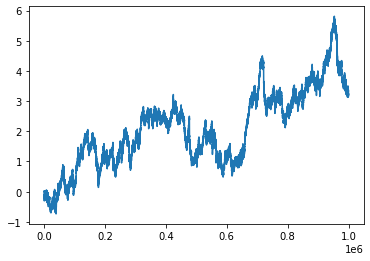

In [41]:
plt.plot(l1-l0)

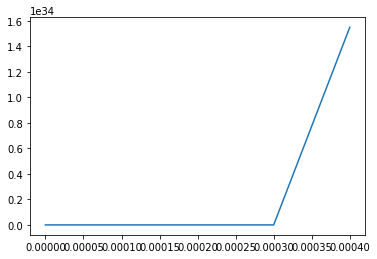

In [11]:
aa = -1
plt.plot(times[:aa], (l0)[:-1][:aa])

In [19]:
def stop_time(itraj, a=-3, b=3):
    pars = give_def_params_discrimination(flip=0) ## H0 is the true hypothesis
    params, exp_path = check_params(pars)
    times, logliks, states1, states0, signals, covs1, covs0 =load_data_discrimination(itraj=itraj, total_time = 4, dt=1e-6, exp_path = exp_path)
    l0,l1 = logliks[:,0], logliks[:,1]
    log_lik_ratio = l1 - l0  ###
    stopping_time_ind =np.argmin(np.logical_and(log_lik_ratio < b, log_lik_ratio > a))
    return times[stopping_time_ind]

In [ ]:
st = []
for itraj in tqdm(range(1,1001)):
    try:
        st.append(stop_time(itraj, b=3, a=-3))
    except Exception:
        pass

  8%|▊         | 76/1000 [02:38<36:44,  2.39s/it]

In [ ]:
counts, bins, bars = plt.hist(st, bins=int(len(st)/5),  density=True)

In [ ]:
def ggiulio_prob(t, b, kappa0, kappa1, eta0 , eta1, n0, n1, gamma0, gamma1):
    Su1 = n1 + 0.5 + (kappa1 / gamma1)
    Su0 = n0 + 0.5 + (kappa0 / gamma0)

    S1 = (np.sqrt(1 + (16.0*eta1*kappa1*Su1/gamma1)) - 1)*(gamma1/(8.0*eta1*kappa1))
    S0 = (np.sqrt(1 + (16.0*eta0*kappa0*Su0/gamma0)) - 1)*( gamma0/(8.0*eta0*kappa0))

    lam = gamma0 + (8*eta0*kappa0*S0)

    aa = (4*eta1*kappa1*(S1**2))/gamma1
    bb =(4*eta0*kappa0*S0**2)*(1+((16.0*eta1*kappa1*S1)/ (gamma1 + lam)) + (64.0*(eta1 * kappa1 * S1)**(2)/(gamma1 * (gamma1 + lam))))/ lam
    c =8 *(S0*S1*(eta0*kappa0 *eta1*kappa1)**(0.5)) * (gamma1+ (4.0*eta1*kappa1*S1) ) / ((gamma1 + lam)*gamma1)

    mu = 4*(eta1*kappa1*aa + (eta0*kappa0*bb) - 2*np.sqrt(eta1*kappa1*eta0*kappa0)*c)
    S= np.sqrt(2*mu)

    div = (np.sqrt(2*np.pi)*S*(t**(3/2)))
    return  abs(b)*np.exp(-((abs(b)-mu*t)**2)/(2*t*(S**2)))/div

In [ ]:
[gamma1, omega1, n1, eta1, kappa1], [gamma0, omega0, n0, eta0, kappa0] = params
gp1 = [ggiulio_prob(t, 3, kappa0, kappa1, eta0, eta1, n0, n1, gamma0,gamma1) for t in times]

In [ ]:
np.save("gp1",gp1)
np.save("stopp_time_1K",counts)
np.save("stopp_time_1K_bins",bins)

In [ ]:
plt.plot(times,gp1,linewidth=5, label="stopping time - giulio")
plt.bar(.5*(bins[1:]+bins[:-1]),counts, alpha=0.75,width=bins[1]-bins[0],color="black", label="simulation")
plt.legend()
plt.savefig("giulio_plot.pdf")

In [167]:
ind_time_sprt_avg_stop_time = np.argmin(np.abs(times - np.mean(stprt_stop["h1"])))

stprt_stop = {}
stprt_stop["h0"] = []
stprt_stop["h1"] = []

np_errs = {}
np_errs["h0/h1"] = []
np_errs["h1/h0"] = []

for itraj in tqdm(range(1000)):
        
    try:

        pars = give_def_params_discrimination(flip=0) ## H0 is the true hypothesis
        params, exp_path = check_params(pars)
        times, logliks, states1, states0, signals, covs1, covs0 =load_data_discrimination(itraj=itraj, total_time = 4, dt=1e-6, exp_path = exp_path)
        l0,l1 = logliks[:,0], logliks[:,1]
        log_lik_ratio = l1 - l0  ###
        
        ### stand up at the equal likelihood point ---> you choose max-likelihood hypothesis!
        h0 = log_lik_ratio[ind_time_sprt_avg_stop_time] <= 0
        np_errs["h0/h1"].append(int(h0))

        #### for the other hypothesis, flip the parameters

        pars = give_def_params_discrimination(h1true=0)
        params, exp_path = check_params(pars)

        times, l0, l1, states, states1, signals, covs, covs1 = load_data_discrimination(exp_path = exp_path, periods = 2, ppp=100000,itraj=itraj)
        log_lik_ratio = (l0-l1)

        ### stand up at the equal likelihood point ---> you choose max-likelihood hypothesis!
        h1 = log_lik_ratio[ind_time_sprt_avg_stop_time] <= 0
        np_errs["h1/h0"].append(int(h1))
    except Exception:
        pass


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 500/500 [00:05<00:00, 91.42it/s]


In [168]:
print(np.mean(np_errs["h0/h1"]), np.mean(np_errs["h1/h0"]))
print(np.mean(sprt_errs["h0/h1"]), np.mean(sprt_errs["h1/h0"]))

0.158 0.816
0.084 0.924


In [173]:
1- np.e

0.049787068367863944

In [70]:
pars = give_def_params_discrimination(h1true=1)
params, exp_path = check_params(pars)

times, l0, l1, states, states1, signals, covs, covs1 = load_data_discrimination(exp_path = exp_path, periods = 2, ppp=100000,itraj=1)
log_lik_ratio = l0-l1

bools = np.logical_and(log_lik_ratio <= b(ep1), a(ep0) <= log_lik_ratio)
indi = np.argmin(bools)
stprt_stop["h1"] = times[indi]

h0 = log_lik_ratio[indi] <= a(ep0)

In [72]:
int(h0)

1

In [40]:
alpha = 0
beta = 0

for itraj in tqdm(range(1,10)):

    pars = give_def_params_discrimination(h1true=1)
    params, exp_path = check_params(pars)
    
    times, l0, l1, states, states1, signals, covs, covs1 = load_data(exp_path = exp_path, periods = 50, ppp=1000, itraj=itraj)
    log_lik_ratio = l0-l1

    bools = np.logical_and(log_lik_ratio <= b(ep1), a(ep0) <= log_lik_ratio)
    indi = np.argmin(bools)

    h1 = log_lik_ratio[indi] >= b(ep1)
    h0 = log_lik_ratio[indi] <= a(ep0)
    
    alpha += h0

  0%|                                                                                                                                                         | 0/9 [00:00<?, ?it/s]


FileNotFoundError: [Errno 2] No such file or directory: '../quantera/trajectories/discrimination/[[1.0, 0, 20, 1.0, 1.0], [0.3, 0, 2, 1.0, 1.0]]/1itraj/rossler_real_traj_method/50periods/1000ppp/1rppp/states.npy'